In [2]:
import os
import sys
import random
import torch
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath("../src"))

from dataset import GarbageDataset
from train import train_transform, val_transform

In [3]:
data_dir = "../data/train"
class_names = sorted([
    name for name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, name)) and not name.startswith(".")
])
print("Classes:", class_names)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}
print("Number of images by class: ")
for cls, count in class_counts.items():
    print(cls, count)

Number of images by class: 
cardboard 282
glass 350
metal 287
paper 415
plastic 337
trash 95


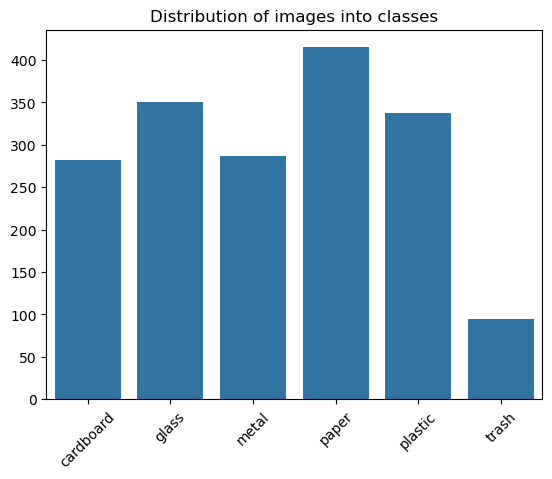

In [5]:
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Distribution of images into classes")
plt.show()

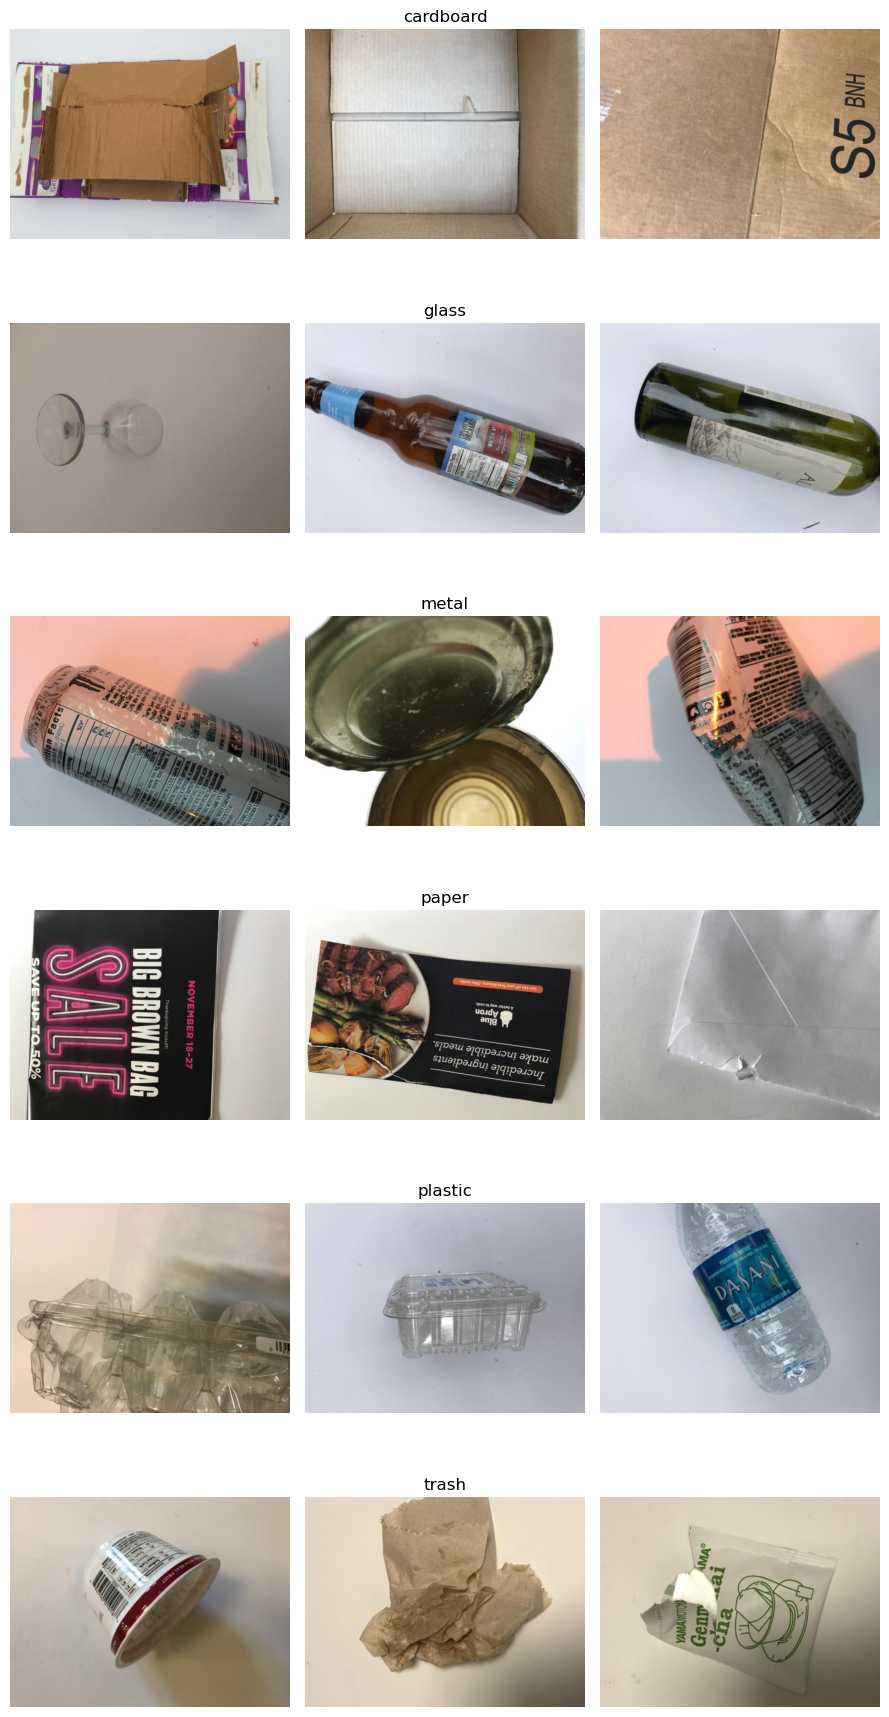

In [7]:
def show_random_images(data_dir, class_names, n_images=3):
    plt.figure(figsize=(n_images * 3, len(class_names) * 3))
    for row, cls in enumerate(class_names):
        images = os.listdir(os.path.join(data_dir, cls))
        samples = random.sample(images, n_images)
        for col, img_name in enumerate(samples):
            img_path = os.path.join(data_dir, cls, img_name)
            img = Image.open(img_path)
            plt.subplot(len(class_names), n_images, row * n_images + col + 1)
            plt.imshow(img)
            plt.axis('off')
            if col == 1:
                plt.title(cls)
    plt.tight_layout()
    plt.show()

show_random_images(data_dir, class_names)

**Class imbalance observation:**
- The dataset contains 6 classes, with `trash` being significantly underrepresented (only 95 images).
- This imbalance may affect the model's ability to recognize the minority class.
- Potential solutions include: class weighting, data augmentation, and oversampling.

In [8]:
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
val_dir = "../data/val"
val_dataset = GarbageDataset(root_dir = val_dir, transform=base_transform)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

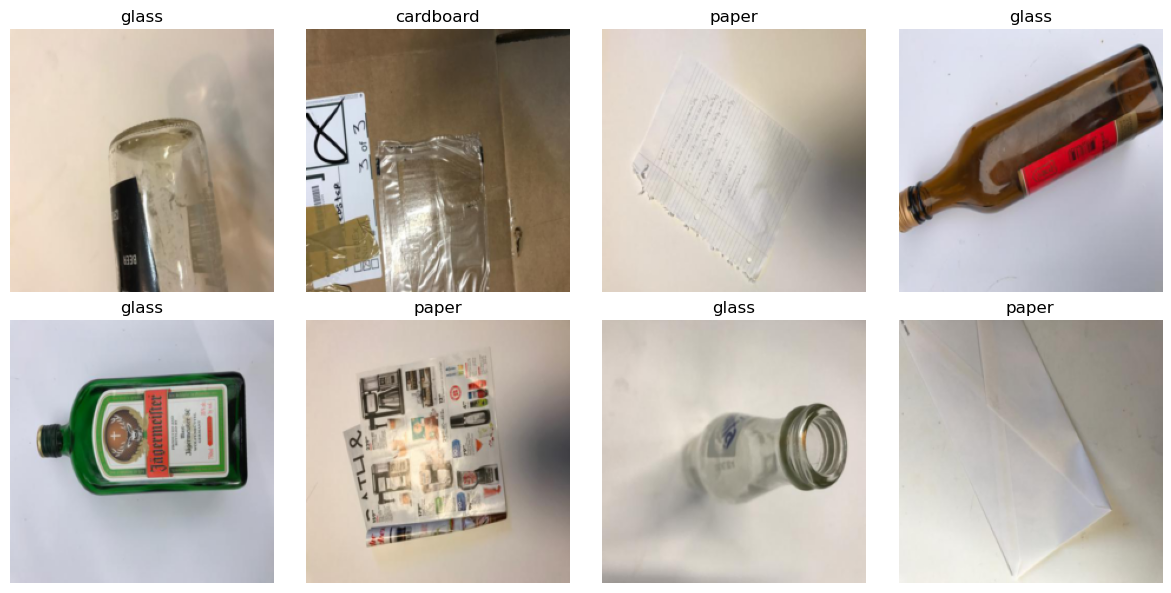

In [30]:
idx_to_class = {v:k for k, v in val_dataset.class_to_idx.items()}

def imshow_batch(images, labels, idx_to_class):
    images = images.permute(0, 2, 3, 1)        # (B, C, H, W) → (B, H, W, C)
    images = images * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    images = images.clamp(0, 1)

    fig, axes = plt.subplots(2, 4, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(idx_to_class[labels[i].item()])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

images, label = next(iter(val_loader))
imshow_batch(images, label, idx_to_class)

In [11]:
train_dir = "../data/train"
train_dataset = GarbageDataset(train_dir, transform=train_transform)
val_dataset = GarbageDataset(val_dir, transform=val_transform)

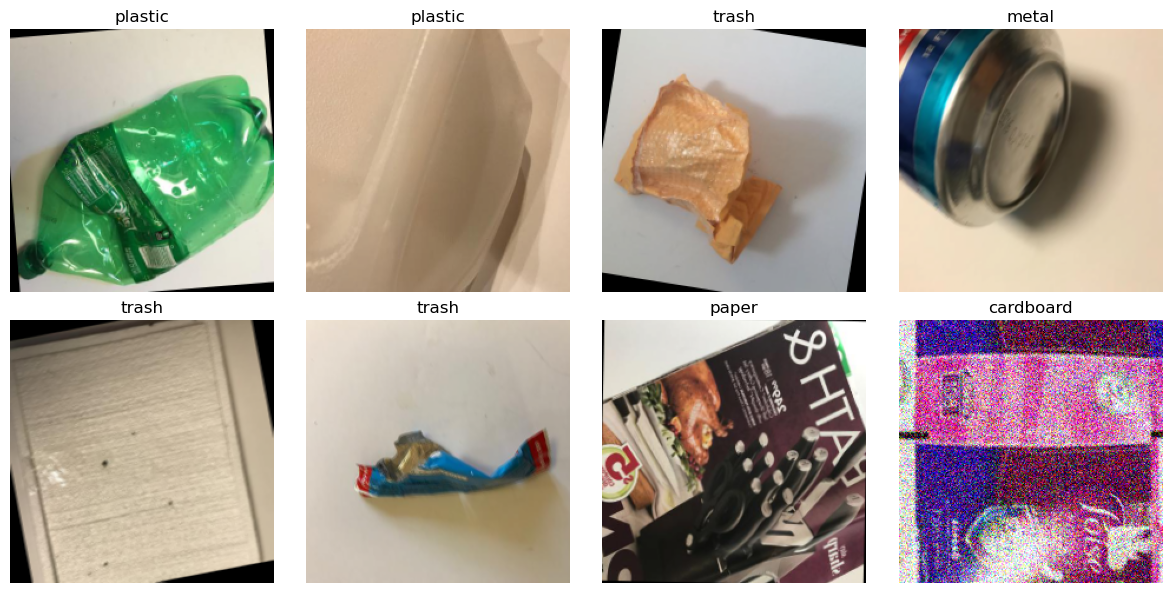

In [13]:
images, labels = next(iter(DataLoader(train_dataset, batch_size=8, shuffle=True)))
imshow_batch(images, labels, idx_to_class)